In [2]:
import pandas as pd
import random
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

#import torchmetrics for Loss and Accyracy libraries and Visualizing
import torchmetrics
from torchmetrics import Accuracy
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


from tqdm.auto import tqdm



In [3]:
# setup Device to CUDA
device='cuda' if torch.cuda.is_available() else 'cpu'
device


'cuda'

In [4]:
!nvidia-smi

Tue Feb  4 09:09:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8             10W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [16]:
train_data=torchvision.datasets.FashionMNIST(root='/kaggle/working/',
                                        train=True,
                                        download=True,
                                        transform=torchvision.transforms.Compose([transforms.ToTensor(),
                                                                                 transforms.Normalize((.5),(.5))]),
                                        target_transform=None)


test_data=torchvision.datasets.FashionMNIST(root='/kaggle/working/',
                                        train=False,
                                        download=True,
                                        transform=torchvision.transforms.Compose([transforms.ToTensor(),
                                                                                 transforms.Normalize((.5),(.5))]),
                                        target_transform=None)


In [17]:
train_dataloader=DataLoader(dataset=train_data,
                            batch_size=16,
                            shuffle=True)

test_dataloader=DataLoader(dataset=test_data,
                           batch_size=16,
                           shuffle=False)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a3eb7d92140>,
 <torch.utils.data.dataloader.DataLoader at 0x7a3eb7d93460>)

In [18]:
train_dataloader.dataset,test_dataloader.dataset,train_dataloader.dataset.class_to_idx


(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: /kaggle/working/
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=0.5, std=0.5)
            ),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: /kaggle/working/
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=0.5, std=0.5)
            ),
 {'T-shirt/top': 0,
  'Trouser': 1,
  'Pullover': 2,
  'Dress': 3,
  'Coat': 4,
  'Sandal': 5,
  'Shirt': 6,
  'Sneaker': 7,
  'Bag': 8,
  'Ankle boot': 9})

In [19]:
image,lable=next(iter(train_dataloader))
image.shape



torch.Size([16, 1, 28, 28])

In [20]:
def create_dataframe_train (dataloader,dataset_name=str):
    len_data=len(dataloader.dataset)
    num_classes=len(dataloader.dataset.classes)
    #class_name=dataloader.dataset.classes
    eg_image,label=next(iter(dataloader))
    image_shape=eg_image.shape
    batch=len(dataloader)
    label_shape=label.shape
    image_type=eg_image.dtype
    data={'Dataset Name':[dataset_name],
          'Number of images':[len_data],
          'Number of Batch':[batch],
          'Number of classes':[num_classes],
          
          'Label shape':[label_shape],
          'Type of images':[image_type],
          'Image shape [N,C,H,W]':[[image_shape]]}
    df=pd.DataFrame(data)
    return df


train_df=create_dataframe_train(train_dataloader,'Train')
test_df=create_dataframe_train(test_dataloader,'Test')


combined_df=pd.concat([train_df,test_df])
combined_df




,Dataset Name,Number of images,Number of Batch,Number of classes,Label shape,Type of images,"Image shape [N,C,H,W]"
0,Train,60000,3750,10,"(16,)",torch.float32,"[(16, 1, 28, 28)]"
0,Test,10000,625,10,"(16,)",torch.float32,"[(16, 1, 28, 28)]"


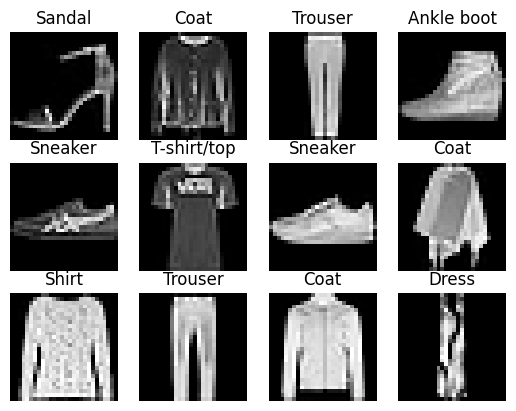

In [21]:
random.seed(42)
test_images_labels=[]

random_inx=random.sample(range(len(test_dataloader)), k=12)  
random_samples=[test_dataloader.dataset[i] for i in random_inx ]
for img,label in random_samples:
    test_images_labels.append((img,label))
   

for inx,(img,label) in enumerate(test_images_labels):

    img=img.permute(1,2,0) # [c,h,w] to [h,w,c]
    plt.subplot(3,4,inx+1)
    plt.imshow(img,cmap='gray')
    plt.axis(False)
    title_text=train_dataloader.dataset.classes[label]
    plt.title(title_text)

In [22]:
len(train_dataloader.dataset),len(train_dataloader)

(60000, 3750)

In [39]:
class ResNetBlock(nn.Module): 
    def __init__(self, in_channels, out_channels, stride=1): 
        super(ResNetBlock, self).__init__() 
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1) 
        self.bn1 = nn.BatchNorm2d(out_channels) 
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1) 
        self.bn2 = nn.BatchNorm2d(out_channels) 
        self.conv3 = nn.Conv2d(out_channels, out_channels , kernel_size=1) 
        self.bn3 = nn.BatchNorm2d(out_channels) 
        self.relu = nn.ReLU()
        self.identity_conv=nn.Conv2d(in_channels,out_channels,kernel_size=1, stride=stride, padding=1)
    def forward(self, x):
        identity = x
        #print(identity.shape)
        x = self.conv1(x) 
        x = self.bn1(x) 
        x = self.relu(x) 
        x = self.conv2(x) 
        x = self.bn2(x) 
        x = self.relu(x) 
        x = self.conv3(x) 
        x = self.bn3(x) 
        #print(x.shape)
        if self.identity_conv is not None: 
            identity = self.identity_conv(identity) 
        if x.shape != identity.shape:
            identity=nn.functional.interpolate(identity,size=(x.shape[2],x.shape[3]),mode='nearest')
            
        x += identity 
        x = self.relu(x) 
        return x 
            
            
class SimpleResNet(nn.Module): 
    def __init__(self, num_classes=10): 
        super(SimpleResNet, self).__init__() 
        self.conv1 = nn.Conv2d(1,16, kernel_size=3, stride=1, padding=1) 
        self.bn1 = nn.BatchNorm2d(16) 
        self.relu = nn.ReLU() 
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=1, padding=1) 
        self.block1 = ResNetBlock(16, 32) 
        self.block2 = ResNetBlock(32,64) 
        #self.block3 = ResNetBlock(32,64 )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) 
        self.flatten=nn.Flatten()
        self.fc = nn.Linear(64 ,128)
        #self.fc2=nn.Linear(128,128)
        #self.drop=nn.Dropout(p=0.5)
        self.fc3=nn.Linear(128,num_classes)
        
        
    def forward(self, x): 
        x = self.conv1(x) 
        
        x = self.bn1(x) 
        x = self.relu(x) 
        x = self.maxpool(x)
        x = self.block1(x) 
        x = self.block2(x) 
        #x = self.block3(x) 
        x = self.avgpool(x) 
        x = self.flatten(x) 
        x = self.fc(x)
       # x=self.fc2(x)
       # x=self.drop(x)
        x=self.fc3(x)
        return x
model1 = SimpleResNet(num_classes=10).to(device)
print(model1)

    

SimpleResNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
  (block1): ResNetBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (identity_conv): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  )
  (block2): ResNetBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1),

In [40]:
loss_fn=nn.CrossEntropyLoss().to(device)
optimizer=torch.optim.SGD(params=model1.parameters(),lr=0.1)
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.1,patience=3,verbose=True)
accuracy=Accuracy(task='multiclass',num_classes=len(train_dataloader.dataset.classes)).to(device)

In [33]:
def train_loop(model=nn.Module,
               data=torch.utils.data.DataLoader,
               loss_fn=nn.Module,
               optimizer=torch.optim.Optimizer,
               scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
               accuracy_fn=torchmetrics,
               device=torch.device):
    torch.cuda.manual_seed(42)
    start_time_train=timer()
    train_acc,train_loss=0,0
    model.train()
    for image,label in data:
        image,label=image.to(device),label.to(device)
        y_pred_prob=model(image)
        loss=loss_fn(y_pred_prob,label)
        train_loss+=loss
        train_acc+=accuracy_fn(label,torch.argmax(y_pred_prob,dim=1))
        #train_acc+=acc


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    scheduler.step(train_loss)
    

    train_acc/=len(data)
    train_loss/=len(data)

    end_time_train=timer()
    current_lr=scheduler.optimizer.param_groups[0]['lr']


    print(f"\033[92m Learinig rate:{current_lr:.6f}\nTrain_loss:{train_loss:.4f}%\n Train_acc:{train_acc:.4f}%\nDevice is on {device}\nTime passed for training:{end_time_train-start_time_train:.2f}s\033[0m")

    return train_acc,train_loss


def test_loop(model=nn.Module,
               data=torch.utils.data.DataLoader,
               loss_fn=nn.Module,
               accuracy_fn=torchmetrics,
               scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
               device=torch.device):
    torch.cuda.manual_seed(42)
    start_time_test=timer()
    test_acc,test_loss=0,0
    model.eval().to(device)
    with torch.inference_mode():
        for image,label in data:
            image,label=image.to(device),label.to(device)
            y_pred_prob=model(image)
            loss=loss_fn(y_pred_prob,label)
            test_loss+=loss
            acc=accuracy_fn(label,y_pred_prob.argmax(dim=1))
            test_acc+=acc
            

        test_acc/=len(data)
        test_loss/=len(data)
        
        end_time_test=timer()


        print(f"\033[94mTest_loss:{test_loss:.4f}%\n Test_acc:{test_acc:.4f}%\nDevice is on {device}\nTime passed for testing:{end_time_test-start_time_test:.2f}s\033[0m")
        scheduler.step(test_loss)
        current_lr=scheduler.optimizer.param_groups[0]['lr']
        print(f'\033[94m Learning Rate after scheduler step:{current_lr:.6f}')

        return test_acc,test_loss


In [41]:
torch.cuda.manual_seed(42)
epochs=20
train_accuracies=[]
train_losses=[]
test_accuracies=[]
test_losses=[]
time_start = timer()
for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}/{epochs}")
    train_acc,train_loss=train_loop(model1,train_dataloader,loss_fn,optimizer, scheduler,accuracy,device=str(next(model1.parameters()).device))
    test_acc,test_loss=test_loop(model1,test_dataloader,loss_fn,accuracy, scheduler,device=str(next(model1.parameters()).device))

    train_losses.append(train_loss.item())
    train_accuracies.append(train_acc.item())
    test_losses.append(test_loss.item())
    test_accuracies.append(test_acc.item())
    print(f"------------------------")
time_end=timer()
print(f'Total time passed :\033[91m{time_end-time_start:.4f}s\033[0m')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0/20
 Learinig rate:0.100000
Train_loss:0.6422%
 Train_acc:0.7618%
Device is on cuda:0
Time passed for training:43.77s
Test_loss:0.4674%
 Test_acc:0.8292%
Device is on cuda:0
Time passed for testing:4.71s
 Learning Rate after scheduler step:0.100000
------------------------
Epoch 1/20
 Learinig rate:0.100000
Train_loss:0.3949%
 Train_acc:0.8556%
Device is on cuda:0
Time passed for training:43.44s
Test_loss:0.3754%
 Test_acc:0.8667%
Device is on cuda:0
Time passed for testing:4.43s
 Learning Rate after scheduler step:0.100000
------------------------
Epoch 2/20
 Learinig rate:0.100000
Train_loss:0.3330%
 Train_acc:0.8778%
Device is on cuda:0
Time passed for training:43.33s
Test_loss:0.3469%
 Test_acc:0.8779%
Device is on cuda:0
Time passed for testing:4.66s
 Learning Rate after scheduler step:0.100000
------------------------
Epoch 3/20
 Learinig rate:0.100000
Train_loss:0.3004%
 Train_acc:0.8919%
Device is on cuda:0
Time passed for training:42.78s
Test_loss:0.4473%
 Test_acc:0.86

In [42]:
import plotly.graph_objects as go

epochs=list(range(1,len(train_accuracies)+1))


train=go.Scatter(x=epochs,
                 y=train_accuracies,
                 mode='lines+markers',
                 name='Train Acc',line=dict(color='royalblue'))



test=go.Scatter(x=epochs,
                 y=test_accuracies,
                 mode='lines+markers',
                 name='Test Acc',line=dict(color='orange'))

figure=go.Figure(data=[train,test])
figure.update_layout(title='Train and Test Accuracy per Epoch',
                    xaxis_title='Epochs',
                    yaxis_title='Accuracy',
                    template='plotly_white')

figure.show()


In [43]:
pochs=list(range(1,len(train_losses)+1))


train=go.Scatter(x=epochs,
                 y=train_losses,
                 mode='lines+markers',
                 name='Train Loss',line=dict(color='red'))



test=go.Scatter(x=epochs,
                 y=test_losses,
                 mode='lines+markers',
                 name='Test Loss',line=dict(color='black'))

figure=go.Figure(data=[train,test])
figure.update_layout(title='Train and Test Loss per Epoch',
                    xaxis_title='Epochs',
                    yaxis_title='Loss',
                    template='plotly_white')

# Predict Model1:

In [44]:

#torch.cuda.manual_seed(42)
test_images_labels=[]

random_inx=random.sample(range(len(test_data)), k=9)
random_samples=[test_data[i] for i in random_inx ]
for img,label in random_samples:
    test_images_labels.append((img,label))

model1.eval()
with torch.inference_mode():
    for img,label in test_images_labels:
        #print(img.shape)
        img=img.unsqueeze(0).to(device)
        #print(img.shape)
        y_logits=model1(img)
        y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)
      
        if label==y_pred.item():
            print(f'\033[92m True label:{label}, Predicted label:{y_pred.item()}\033[0m')
        else:
            print(f'\033[91m True label:{label}, Predicted label:{y_pred.item()}\033[0m')

 True label:1, Predicted label:1
 True label:2, Predicted label:2
 True label:2, Predicted label:2
 True label:1, Predicted label:1
 True label:4, Predicted label:4
 True label:4, Predicted label:4
 True label:5, Predicted label:5
 True label:6, Predicted label:6
 True label:6, Predicted label:6


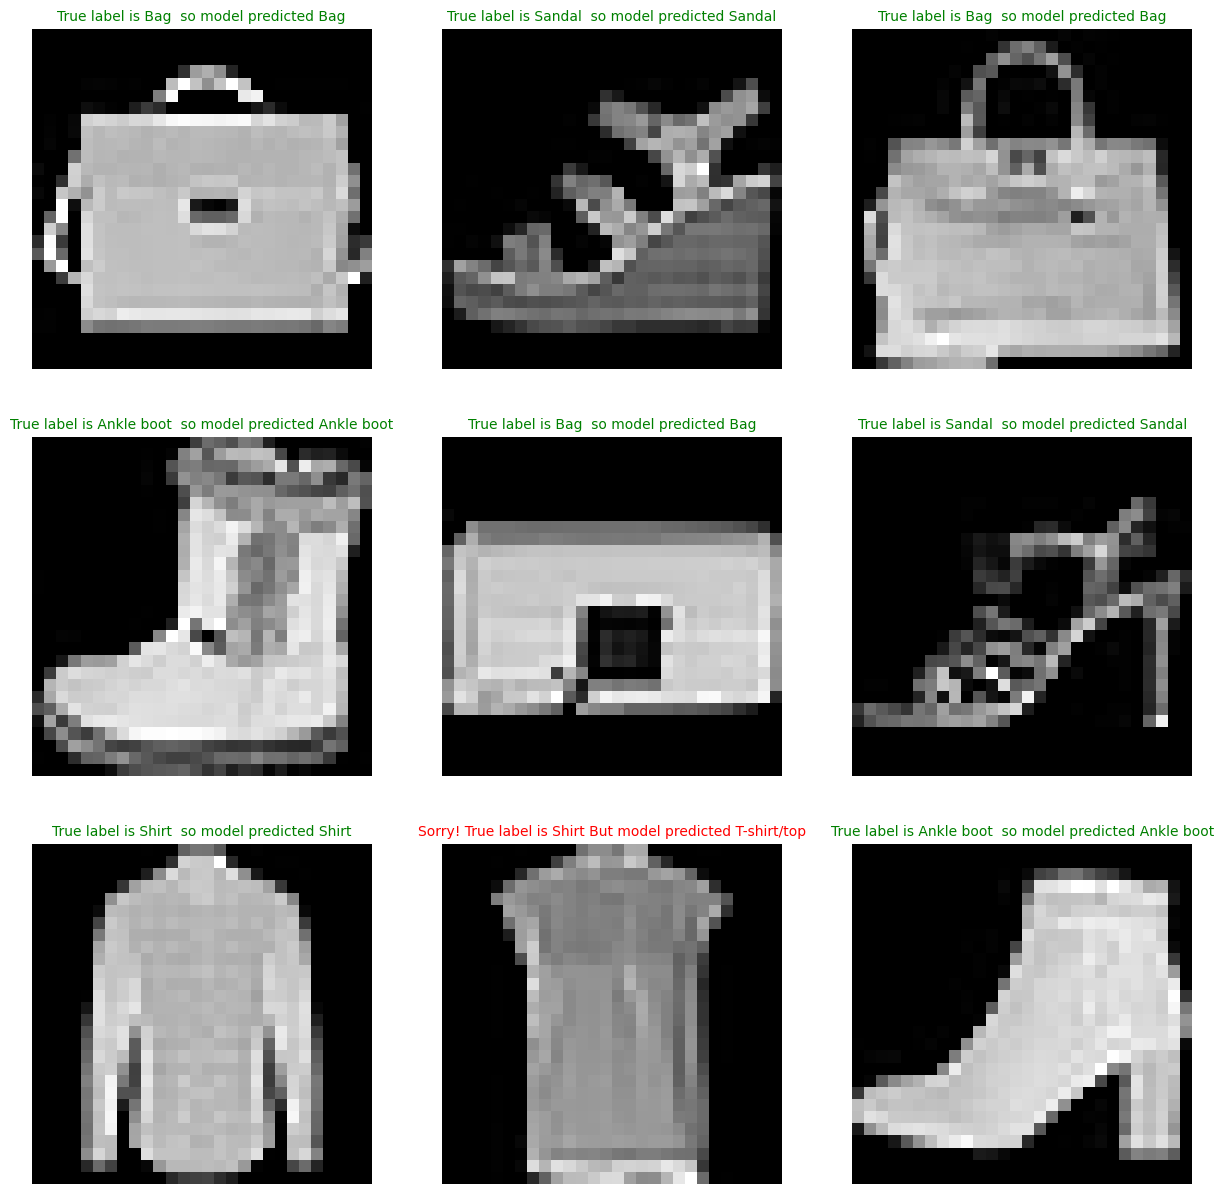

In [47]:
import random
#random.seed(42)
test_images_labels=[]

random_inx=random.sample(range(len(test_data)), k=9)  # or with test_dataloader
random_samples=[test_data[i] for i in random_inx ]
for img,label in random_samples:
    test_images_labels.append((img,label))

y_preds=[]
model1.eval()
with torch.inference_mode():
    plt.figure(figsize=(15,15))
    for inx,(img,label) in enumerate(test_images_labels):
        img_model=img.unsqueeze(0).to(device)
        img=img.permute(1,2,0)
        #print(img.shape)
        
        y_logits=model1(img_model)
        y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)
        y_preds.append(y_pred)
        plt.subplot(3,3,inx+1)
        plt.imshow(img.squeeze(0),cmap='gray')
        plt.axis(False)
        title_true_text=f'True label is {train_data.classes[label]}  so model predicted {train_data.classes[y_pred.item()]}'
        title_false_text=f'Sorry! True label is {train_data.classes[label]} But model predicted {train_data.classes[y_pred.item()]}'
        if label==y_pred.item():
            plt.title(title_true_text,fontsize=10, c="g")
        else:
            plt.title(title_false_text,fontsize=10, c="r")
y_pred_tensor =torch.cat(y_preds,dim=0)    

In [48]:
print(f'After `torch.cat`:\n {y_pred_tensor}\n-----------------------------\n Before `torch.cat`:\n{y_preds}')

After `torch.cat`:
 tensor([8, 5, 8, 9, 8, 5, 6, 0, 9], device='cuda:0')
-----------------------------
 Before `torch.cat`:
[tensor([8], device='cuda:0'), tensor([5], device='cuda:0'), tensor([8], device='cuda:0'), tensor([9], device='cuda:0'), tensor([8], device='cuda:0'), tensor([5], device='cuda:0'), tensor([6], device='cuda:0'), tensor([0], device='cuda:0'), tensor([9], device='cuda:0')]


# ConfusionMatrix:

In [52]:
# 1. Make predictions with trained model
y_preds =[]
torch.cuda.manual_seed(42)
model1.eval()
with torch.inference_mode():
  for img,label in test_data:

      image= img.to(device) 
     
    # Do the forward pass
      y_logit = model1(image.unsqueeze(0))
    # Turn predictions from logits -> prediction probabilities -> predictions labels
      y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    #y_pred=y_logit.argmax(dim=1)
      # Put predictions on CPU for evaluation(plt)
      y_preds.append(y_pred.cpu())
#print(y_pred.shape)
# Concatenate list of predictions into a tensor
y_pred_tensor =torch.cat(y_preds,dim=0)


In [53]:
preds=y_pred_tensor.long()
target=torch.tensor(test_data.targets).long()

<ipython-input-53-8c32256f37ba>:2: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



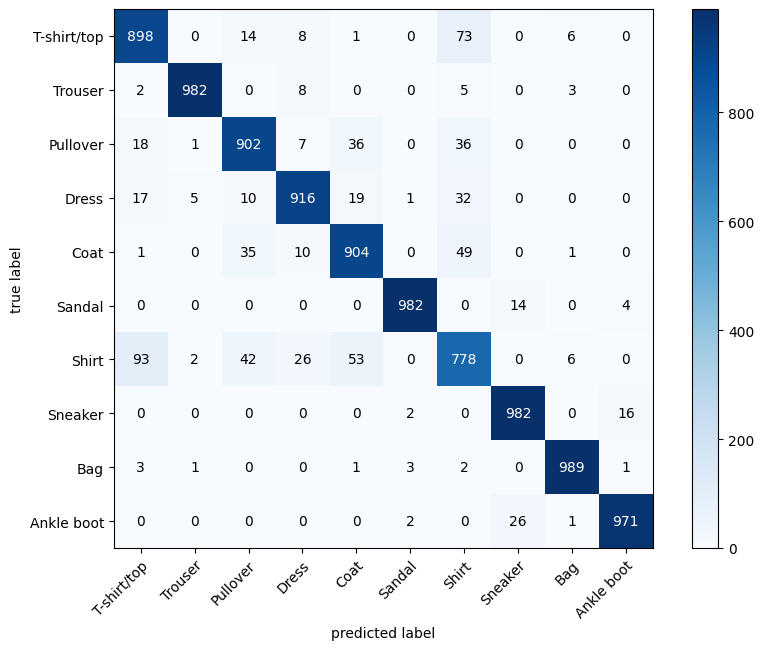

In [54]:
# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(train_data.classes), task='multiclass')
confmat_tensor = confmat(preds=preds,
                        target=target)

#3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
                                class_names=train_data.classes,colorbar=True, # turn the row and column labels into class names
                              
                                figsize=(10, 7));